# 1. Library & Input data

In [2]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')

from datetime import datetime
from unidecode import unidecode
from itertools import combinations

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import roc_auc_score

from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

import category_encoders as ce

import re
import warnings
warnings.filterwarnings('ignore')

# import os
# for dirname, _, filenames in os.walk('data'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

ModuleNotFoundError: No module named 'catboost'

In [11]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
province = pd.read_csv('data/diaChi_province.csv')

C:\Users\Thanh Cong\miniconda3\lib\site-packages\IPython\core\interactiveshell.py:3145: DtypeWarning: Columns (35,43) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
C:\Users\Thanh Cong\miniconda3\lib\site-packages\IPython\core\interactiveshell.py:3145: DtypeWarning: Columns (34,42) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


# 2. Feature Engineering

In [3]:
# Drop some columns are duplicated, with correlation = NaN
ignore_columns = (["gioiTinh", "info_social_sex", "ngaySinh", "namSinh"] + 
        [f"Field_{c}" for c in [14, 16, 17, 24, 26, 30, 31, 37, 52, 57]] + 
        ['partner0_K', 'partner0_L', 
         'partner1_B', 'partner1_D', 'partner1_E', 'partner1_F', 'partner1_K', 'partner1_L',
         'partner2_B', 'partner2_G', 'partner2_K', 'partner2_L',
         'partner3_B', 'partner3_C', 'partner3_F', 'partner3_G', 'partner3_H', 'partner3_K', 'partner3_L',
         *['partner4_' + i for i in 'ABCDEFGHK'],
         'partner5_B', 'partner5_C', 'partner5_H', 'partner5_K', 'partner5_L'])

# Some auto columns could make new better columns
all_auto_columns = list(set([c for c in train.columns if train[c].dtype in [np.int64, np.float64]])
                    .difference(ignore_columns + ['currentLocationLocationId', 'homeTownLocationId', 'label', 'id']))

auto_columns_1 = [c for c in all_auto_columns if 'Field_' in c]
auto_columns_2 = [c for c in all_auto_columns if 'partner' in c]
auto_columns_3 = [c for c in all_auto_columns if 'num' in c]
auto_columns_4 = [c for c in all_auto_columns if c not in auto_columns_1 + auto_columns_2 + auto_columns_3]
print(len(auto_columns_1), len(auto_columns_2), len(auto_columns_3), len(auto_columns_4), len(all_auto_columns))

37 27 12 11 87


### 2.1. Datetime columns

In [4]:
date_cols = ["Field_{}".format(i) for i in [5, 6, 7, 8, 9, 11, 15, 25, 32, 33, 35, 40]]
datetime_cols = ["Field_{}".format(i) for i in [1, 2, 43, 44]]
correct_dt_cols = ['Field_34', 'ngaySinh']
cat_cols = date_cols + datetime_cols + correct_dt_cols

# Normalize Field_34, ngaySinh
def ngaysinh_34_normalize(s):
    if s != s: return np.nan
    try: s = int(s)
    except ValueError: s = s.split(" ")[0]
    return datetime.strptime(str(s)[:6], "%Y%m")

# Normalize datetime data
def datetime_normalize(s):
    if s != s: return np.nan
    s = s.split(".")[0]
    if s[-1] == "Z": s = s[:-1]
    return datetime.strptime(s, "%Y-%m-%dT%H:%M:%S")

# Normalize date data
def date_normalize(s):
    if s != s: return np.nan
    try: t = datetime.strptime(s, "%m/%d/%Y")
    except: t = datetime.strptime(s, "%Y-%m-%d")
    return t

def process_datetime_cols(df):
    df[datetime_cols] = df[datetime_cols].applymap(datetime_normalize)  
    df[date_cols] = df[date_cols].applymap(date_normalize)
    df[correct_dt_cols] = df[correct_dt_cols].applymap(ngaysinh_34_normalize)

    # Some delta columns
    for i, j in zip('43 1 2'.split(), '1 2 44'.split()): df[f'DT_{j}_{i}'] = (df[f'Field_{j}'] - df[f'Field_{i}']).dt.seconds
    for i, j in zip('5 6 7 33 8 11 9 15 25 6 7 8 9 15 25 2'.split(), '6 34 33 40 11 35 15 25 32 7 8 9 15 25 32 8'.split()): 
        df[f'DT_{j}_{i}'] = (df[f'Field_{j}'] - df[f'Field_{i}']).dt.days
    
    # Age, month
    df['age'] = 2020 - pd.DatetimeIndex(df['ngaySinh']).year
    df['birth_month'] = pd.DatetimeIndex(df['ngaySinh']).month
    
    # Days from current time & isWeekday
    for col in cat_cols:
        name = col.split('_')[-1]
        df[f'is_WD_{name}'] = df[col].dt.dayofweek.isin(range(5))
        df[f'days_from_now_{name}'] = (datetime.now() - pd.DatetimeIndex(df[col])).days
        df[col] = df[col].dt.strftime('%m-%Y')
    
    # Delta for x_startDate and x_endDate
    for cat in ['F', 'E', 'C', 'G', 'A']:
        df[f'{cat}_startDate'] = pd.to_datetime(df[f"{cat}_startDate"], infer_datetime_format=True)
        df[f'{cat}_endDate'] = pd.to_datetime(df[f"{cat}_endDate"], infer_datetime_format=True)
        
        df[f'{cat}_start_end'] = (df[f'{cat}_endDate'] - df[f'{cat}_startDate']).dt.days
        
    
    temp_date = [f'{i}_startDate' for i in 'ACEFG'] + [f'{i}_endDate' for i in 'ACEFG']
    
    for col in temp_date:
        df[col] = df[col].dt.strftime('%m-%Y')
        
    for col in cat_cols + temp_date:
        df[col] = df[col].astype("category")
        
    return df

### 2.2. Categorical columns

In [5]:
# Xử lý cột maCv

def str_normalize(s):
    s = str(s).strip().lower()
    s = re.sub(' +', " ", s)
    return s


def job_category(x):
    if type(x) == str:
        if "công nhân" in x or "cnv" in x or "cn" in x or "may công nghiệp" in x or "lao động" in x\
        or "thợ" in x or "coõng nhaõn trửùc tieỏp maựy may coõng nghieọp" in x or "c.n" in x or "lđ" in x:
            return "CN"
        elif "giáo viên" in x or "gv" in x or "gíao viên" in x:
            return "GV"
        elif "nhân viên" in x or "kế toán" in x or "cán bộ" in x or "nv" in x or "cb" in x or "nhõn viờn" in x:
            return "NV"
        elif "tài xế" in x or "lái" in x or "tài xê" in x:
            return "TX"
        elif "quản lý" in x or "phó phòng" in x or "hiệu phó" in x:
            return "QL"
        elif "undefined" in x:
            return "missing"
        elif "giám đốc" in x or "hiệu trưởng" in x:
            return "GĐ"
        elif "phục vụ" in x:
            return "PV"
        elif "chuyên viên" in x:
            return  "CV"
        elif "bác sĩ" in x or "dược sĩ" in x or "y sĩ" in x or "y sỹ" in x:
            return "BS"
        elif "y tá" in x:
            return "YT"
        elif "hộ sinh" in x:
            return "HS"
        elif "chủ tịch" in x:
            return "CT"
        elif "bếp" in x:
            return "ĐB"
        elif "sư" in x:
            return "KS"
        elif "dưỡng" in x:
            return "ĐD"
        elif "kỹ thuật" in x or "kĩ thuật" in x:
            return "KTV"
        elif "diễn viên" in x:
            return "DV"
#         else:
#             return "missing"
    else:
        return x    
    
def process_maCv(df):
    df["maCv"] = df["maCv"].apply(str_normalize).apply(job_category)
    df["maCv"] = df["maCv"].astype("category")
    return df


In [6]:
unicode_cols = ['Field_18', 'Field_46', 'Field_48', 'Field_49', 'Field_56', 'Field_61', 'homeTownCity', 
                'homeTownName', 'currentLocationCity', 'currentLocationName', 'currentLocationState', 'homeTownState']
object_cols = (unicode_cols + 
               [f'Field_{str(i)}' for i in '4 12 36 38 47 62 45 54 65 66 68'.split()] +
               ['data.basic_info.locale', 'currentLocationCountry', 'homeTownCountry', 'brief'])

def str_normalize(s):
    s = str(s).strip().lower()
    s = re.sub(' +', " ", s)
    return s

def combine_gender(s):
    x, y = s 
    if x != x and y != y: return "nan"
    if x != x: return y.lower()
    return x.lower()

def process_categorical_cols(df):
    df[unicode_cols] = df[unicode_cols].applymap(str_normalize).applymap(lambda x: unidecode(x) if x==x else x)
    
    # Normalize some columns
    df["Field_38"] = df["Field_38"].map({0: 0.0, 1: 1.0, "DN": np.nan, "TN": np.nan, "GD": np.nan})
    df["Field_62"] = df["Field_62"].map({"I": 1, "II": 2, "III": 3, "IV": 4, "V": 5, "Ngoài quốc doanh Quận 7": np.nan})
    df["Field_47"] = df["Field_47"].map({"Zezo": 0, "One": 1, "Two": 2, "Three": 3, "Four": 4})
    
    # Make some new features
    df['Field_45_Q'] = df['Field_45'].str[:-3].astype('category')
    df['Field_45'] = df['Field_45'].str[2:].astype('category')

    df['is_homeTown_current_state'] = df['homeTownState'] == df['currentLocationState']
    df['F48_49'] = df['Field_48'] == df['Field_49']
    
    df["gender"] = df[["gioiTinh", "info_social_sex"]].apply(combine_gender, axis=1).astype("category")
    
    df[["currentLocationLocationId", "homeTownLocationId", "currentLocationLatitude", "currentLocationLongitude", 
        "homeTownLatitude", "homeTownLongitude"]].replace(0, np.nan, inplace=True) # value == 0: noisy

    df[["currentLocationLocationId", "homeTownLocationId"]] = (df[["currentLocationLocationId", "homeTownLocationId"]]
                                                             .applymap(str_normalize).astype("category"))
    df[object_cols] = df[object_cols].astype('category')
    
    return df

### 2.3. Others

In [7]:
# New feature from columns 63, 64
def process_63_64(z):
    x, y = z
    if x != x and y != y:
        return np.nan
    if (x, y) in [(1.0, 2.0), (2.0, 3.0), (3.0, 4.0), (4.0, 8.0), (7.0, 5.0), (5.0, 6.0), (9.0, 43.0), (8.0, 9.0)]: return True
    else: return False
    
def process_others(df):        
    df[["Field_27", "Field_28"]].replace(0.0, np.nan, inplace=True)
    df['F18_isnumeric'] = df['Field_18'].str.isnumeric()
    df['F18_isalpha'] = df['Field_18'].str.isalpha()
    
    # Round Field_71 và Field_72, Field_79, Field_80
    df['Field_71'] = df.Field_71.round(2)
    df['Field_72'] = df.Field_72.round(2)
    df['Field_79'] = df.Field_79.round(2)
    df['Field_80'] = df.Field_80.round(2)
    
    # Delta from some pairs of columns
    for i, j in [(20, 27), (28, 27), (39, 41), (41, 42), (50, 51), (51, 53)]:
        df[f'F{str(i)}_{str(j)}_delta'] = df[f'Field_{str(j)}'] - df[f'Field_{str(i)}']
    df['F_59_60'] = df['Field_59'] - df['Field_60'] - 2
    df['F_63_64'] = df[['Field_63', 'Field_64']].apply(process_63_64, axis=1).astype('category')
    
    # Mean, std from partnerX columns
    for i in '1 2 3 4 5'.split():
        col = [c for c in df.columns if f'partner{i}' in c]
        df[f'partner{i}_mean'] = df[col].mean(axis=1)
        df[f'partner{i}_std'] = df[col].std(axis=1)

    # Reference columns
    columns = set(df.columns).difference(ignore_columns)
    df['cnt_NaN'] = df[columns].isna().sum(axis=1)
    df['cnt_True'] = df[columns].applymap(lambda x: isinstance(x, bool) and x).sum(axis=1)
    df['cnt_False'] = df[columns].applymap(lambda x: isinstance(x, bool) and not x).sum(axis=1)

    # Combinations of auto columns
    lst_combination = (list(combinations(auto_columns_2, 2)) + list(combinations(auto_columns_3, 2)) + list(combinations(auto_columns_4, 2)))
    for l, r in lst_combination:
        for func in 'add subtract divide multiply'.split():
            df[f'auto_{func}_{l}_{r}'] = getattr(np, func)(df[l], df[r])
            
    return df

In [16]:
# Xử lý Field_55
# tạo thêm 2 cột mới bằng các tách các giá trị trong Field_55 làm 2
def process_55(df):
    df_len = len(df)
    arr1 = df.Field_55.values
    a1 = []
    a2 = []
    for i in range(df_len):
        if type(arr1[i]) == str:
            a1.append(arr1[i][0])
            a2.append(arr1[i][1])
        else:
            a2.append(np.nan)
            a1.append(np.nan)
    df['Field_55_a'] = a1
    df['Field_55_b'] = a2

    # Ép kiểu dữ liệu về dạng category
    df['Field_55_a'] = df['Field_55_a'].astype('category')
    df['Field_55_b'] = df['Field_55_b'].astype('category')

    df.drop('Field_55', axis=1, inplace=True)
    return df

### 2.4. Combine all parts

In [9]:
def transform(df):
    df = process_datetime_cols(df)
    df = process_categorical_cols(df)
    df = process_others(df)
    df = process_maCv(df)
    df = process_55(df)
    return df.drop(ignore_columns, axis=1)

train = transform(train)
test = transform(test)

In [10]:
train['province'] = province.province[:53030]
test['province'] = province.province[53030:]

train['province'] = train['province'].astype('category')
test['province'] = test['province'].astype('category')

### 2.5. Try Count Encoding

In [11]:
# Support catboost modelling
cat_features = [c for c in train.columns if (train[c].dtype not in [np.float64, np.int64])]
train[cat_features] = train[cat_features].astype(str)
test[cat_features] = test[cat_features].astype(str)

In [12]:
# Create the encoder
t = pd.concat([train, test]).reset_index(drop=True)
count_enc = ce.CountEncoder().fit_transform(t[cat_features])
tt = t.join(count_enc.add_suffix("_count"))

f2_train = tt.loc[tt.index < train.shape[0]]
f2_test = tt.loc[tt.index >= train.shape[0]]

columns = sorted(set(f2_train.columns).intersection(f2_test.columns))
print(len(columns))

2210


# 3. Modelling

### 3.1. Model

In [13]:
gini, feature_importance_df = {}, pd.DataFrame()

TRAIN, TEST = f2_train[columns].drop(['id', 'label'], axis=1), f2_test[columns].drop(['id', 'label'], axis=1)
LABEL = f2_train['label']
preds, oof_preds = np.zeros(TRAIN.shape[0]), {}

cv = StratifiedKFold(n_splits=5, shuffle=True)
for i, (train_idx, val_idx) in enumerate(cv.split(TRAIN, LABEL)):
    X_train, y_train = TRAIN.iloc[train_idx], LABEL.iloc[train_idx]
    X_val, y_val = TRAIN.iloc[val_idx], LABEL.iloc[val_idx]

    gbm = CatBoostClassifier(eval_metric='AUC', 
                             use_best_model=True,
                             iterations=1000, 
                             learning_rate=0.1, 
                             random_seed=42).fit(X_train, y_train, 
                                                 cat_features=set(cat_features),
                                                 eval_set=(X_val, y_val), verbose=500)

    y_pred = gbm.predict(X_val)
    y_pred_proba = gbm.predict_proba(X_val)[:, 1]
        
    preds[val_idx] = y_pred_proba
    oof_preds[f'F{i+1}'] = gbm.predict_proba(TEST)[:, 1]
    
    gini[f'F{i+1}'] = 2 * roc_auc_score(y_val, y_pred_proba) - 1
    
    # For create feature importances
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = TRAIN.columns
    fold_importance_df["importance"] = gbm.feature_importances_
    fold_importance_df["fold"] = i + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    print('Fold %2d GINI : %.5f' % (i + 1, 2*roc_auc_score(y_val, y_pred_proba) - 1))
    
# Resulting
roc_auc = roc_auc_score(LABEL, preds)
print('Avg GINI score:', 2*roc_auc - 1)

result = np.array(list(gini.values()))
print('GINI: {:.5f} +- {:.5f}'.format(result.mean(), result.std()))

0:	test: 0.6816828	best: 0.6816828 (0)	total: 1.02s	remaining: 17m
500:	test: 0.7500669	best: 0.7506290 (398)	total: 5m 22s	remaining: 5m 21s
999:	test: 0.7504472	best: 0.7518286 (625)	total: 10m 35s	remaining: 0us

bestTest = 0.751828554
bestIteration = 625

Shrink model to first 626 iterations.
Fold  1 GINI : 0.50366
0:	test: 0.6795202	best: 0.6795202 (0)	total: 774ms	remaining: 12m 52s
500:	test: 0.7540294	best: 0.7551069 (396)	total: 5m 23s	remaining: 5m 22s
999:	test: 0.7535870	best: 0.7551069 (396)	total: 10m 37s	remaining: 0us

bestTest = 0.7551069063
bestIteration = 396

Shrink model to first 397 iterations.
Fold  2 GINI : 0.51021
0:	test: 0.6954428	best: 0.6954428 (0)	total: 743ms	remaining: 12m 22s
500:	test: 0.7483989	best: 0.7487193 (474)	total: 5m 18s	remaining: 5m 17s
999:	test: 0.7493355	best: 0.7495778 (886)	total: 10m 28s	remaining: 0us

bestTest = 0.7495777888
bestIteration = 886

Shrink model to first 887 iterations.
Fold  3 GINI : 0.49916
0:	test: 0.6861750	best: 0.

### 3.2. Feature importances

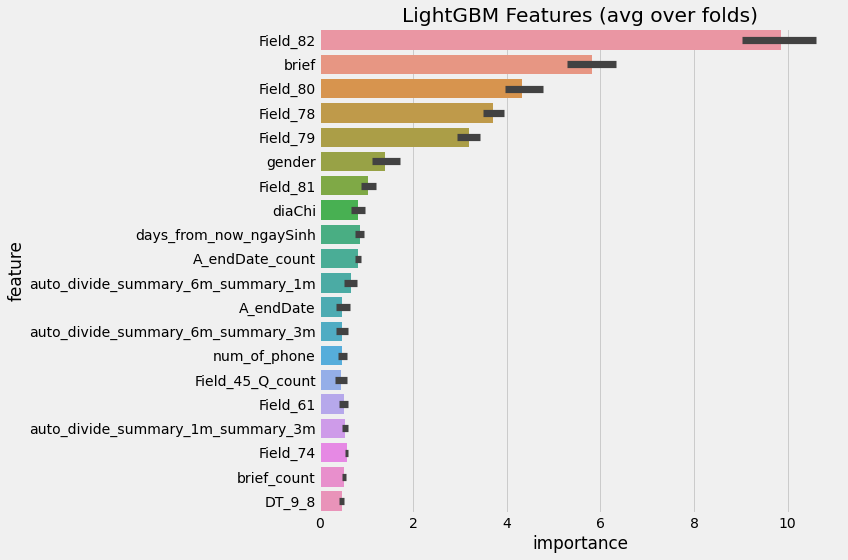

In [14]:
def display_importances(feature_importance_df_):

    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(
        by="importance", ascending=False)[:20].index
    
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    
    plt.figure(figsize=(12, 8))
    sns.barplot(x="importance", y="feature", 
                data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()

display_importances(feature_importance_df_=feature_importance_df)

In [15]:
feature_importance_df[feature_importance_df.feature == 'province']

,feature,importance,fold
2200,province,0.154790,1
2200,province,0.411531,2
2200,province,0.380487,3
2200,province,0.468140,4
2200,province,0.320840,5


In [16]:
# One tips to better performance is re-training the model with dropped low important columns
to_drop = feature_importance_df[feature_importance_df.importance == 0]['feature'].unique()
to_drop.shape

(1852,)

# 4. Submisison

In [17]:
test['label'] = pd.DataFrame(oof_preds).mean(axis=1).values
name = pd.Timestamp.now().strftime('%Y%m%d_%H_%M')
test[['id', 'label']].to_csv(f'{name}.csv', index=False)